/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-28 10:00:00.301677: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-28 10:00:00.301867: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-28 10:00:01.227834: I external/local_xla/xla/stream_executor/cuda/cuda_execut

14536120/14536120 [==============================] - 0s 0us/step


2025-02-28 10:00:04.575007: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90100


35363/35363 [==============================] - 0s 1us/step
Predictions:
lynx: 29.38%
plastic_bag: 14.75%
tiger_cat: 8.90%


  0%|                                                                                                                                                                                          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 305ms/step


 10%|█████████████████▋                                                                                                                                                               | 10/100 [00:00<00:03, 27.36it/s]

1/1 [==============================] - 0s 100ms/step


 20%|███████████████████████████████████▍                                                                                                                                             | 20/100 [00:00<00:01, 40.79it/s]

1/1 [==============================] - 0s 20ms/step


 35%|█████████████████████████████████████████████████████████████▉                                                                                                                   | 35/100 [00:00<00:00, 68.61it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 50/100 [00:00<00:00, 79.00it/s]

1/1 [==============================] - 0s 21ms/step


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 67/100 [00:00<00:00, 101.49it/s]

1/1 [==============================] - 0s 20ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 80/100 [00:01<00:00, 97.92it/s]

1/1 [==============================] - 0s 18ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 97/100 [00:01<00:00, 115.90it/s]

1/1 [==============================] - 0s 18ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 83.79it/s]


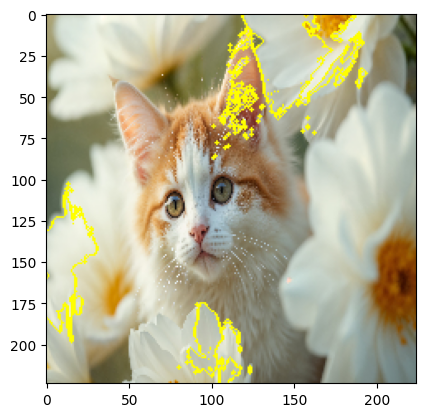

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Load a pre-trained MobileNetV2 model (for simplicity, we'll use it for classification)
model = MobileNetV2(weights='imagenet')

# Load and preprocess an image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return img_array, img

# Load image and preprocess
img_path = 'images/cat.jpg' # Replace with your image path
preprocessed_img, original_img = preprocess_image(img_path)

# Make a prediction
predictions = model.predict(preprocessed_img)
decoded_predictions = tf.keras.applications.mobilenet_v2.decode_predictions(predictions, top=3)[0]

print("Predictions:")
for _, label, confidence in decoded_predictions:
    print(f"{label}: {confidence * 100:.2f}%")

# LIME Explanation (for image classification)
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    image=image.img_to_array(original_img),
    classifier_fn=model.predict,
    top_labels=1,
    hide_color=0,
    num_samples=100
)

# Visualize the explanation
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=False,
    num_features=5,
    hide_rest=False
)

plt.imshow(mark_boundaries(image.img_to_array(original_img) / 255.0, mask))
plt.show()

# Grad-CAM (Gradient-weighted Class Activation Mapping)

def grad_cam(img_array, model, layer_name="block_15_project"): #common last layer for MobileNetV2
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, np.argmax(predictions[0])]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap.numpy()[0]

heatmap = grad_cam(preprocessed_img, model)

# Overlay heatmap on original image
original_img_array = image.img_to_array(original_img) / 255.0
heatmap = cv2.resize(heatmap, (original_img_array.shape[1], original_img_array.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + original_img_array * 0.6
plt.imshow(superimposed_img)
plt.show()